In [67]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from IPython import embed
from matplotlib.patches import Rectangle
from matplotlib.cm import get_cmap

In [68]:
#plt.style.use('fivethirtyeight')
# make the plots white background
plt.style.use('seaborn-poster')


/tmp/ipykernel_2609476/2470672014.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


# RQ 1,2,3,4,5

In [69]:
data_dir = "/home/roger/Desktop/rllte/mario_q12345"
algorithms = ["Extrinsic", "RND", "ICM", "E3B", "PseudoCounts", "RIDE", "RE3", "NGU", "Disagreement"]
# Initialize an empty list to store dataframes for each experiment
dfs = []
cmap = get_cmap('tab20')

# Loop through each subfolder
for subdir in os.listdir(data_dir):
    # Define the path to the current subfolder
    subfolder_path = os.path.join(data_dir, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each file in the subfolder
        for file in os.listdir(subfolder_path):
            if file == ".DS_Store":
                continue
            
            algo_name = None
            for element in algorithms:
                if element.lower() in file:
                    algo_name = element

            try:
                # Define the path to the file
                file_path = os.path.join(subfolder_path, file)
                nested = os.listdir(file_path)

                seed = file_path.split("_")[-1][-1]
                if ".DS_Store" in nested:
                    nested.remove(".DS_Store")
                nested = nested[0]
                
                file_path = os.path.join(file_path, nested, "train.log")
                # Read the data from the file into a dataframe
                df = pd.read_csv(file_path)

                # Add a column to identify the algorithm
                df['RQ'] = subdir
                df["Algorithm"] = algo_name
                df['Seed'] = seed
                
                # keep last 100 episodes
                df = df.iloc[-1000:]
                
                # Append the dataframe to the list
                dfs.append(df)
            except:
                print("Error with file: ", file_path)
                continue
            
# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_2609476/1336397817.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


Error with file:  /home/roger/Desktop/rllte/mario_q12345/baseline/PPO_SuperMarioBros-1-1-v3_extrinsic_obsRMS:False_rewNorm:rms_updateProp:1.0_rff:False_s1/2024-02-12-05-32-43/train.log
Error with file:  /home/roger/Desktop/rllte/mario_q12345/obs. norm./PPO_SuperMarioBros-1-1-v3_re3_obsRMS:True_rewNorm:rms_updateProp:1.0_rff:False_s1/2024-02-13-07-43-46/train.log


In [70]:

# compute the mean and std only on the last 100 episodes
summary_stats = data.groupby(['RQ', 'Algorithm'])['episode_reward'].agg(['mean', 'std']).reset_index()
summary_stats['mean_normalized'] = (summary_stats['mean'] - 0) / (30 - 0)  # Min-max normalization
summary_stats['std_normalized'] = (summary_stats['std'] - 0) / (30 - 0)  / 1.25# Min-max normalization 
df = summary_stats

# remove extrinsic 
df = df[df['Algorithm'] != 'Extrinsic']

algos = np.unique(df['Algorithm'])
RQs = np.unique(df['RQ'])

/tmp/ipykernel_2609476/363232684.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels_names)  # Set y-axis labels for the first subplot


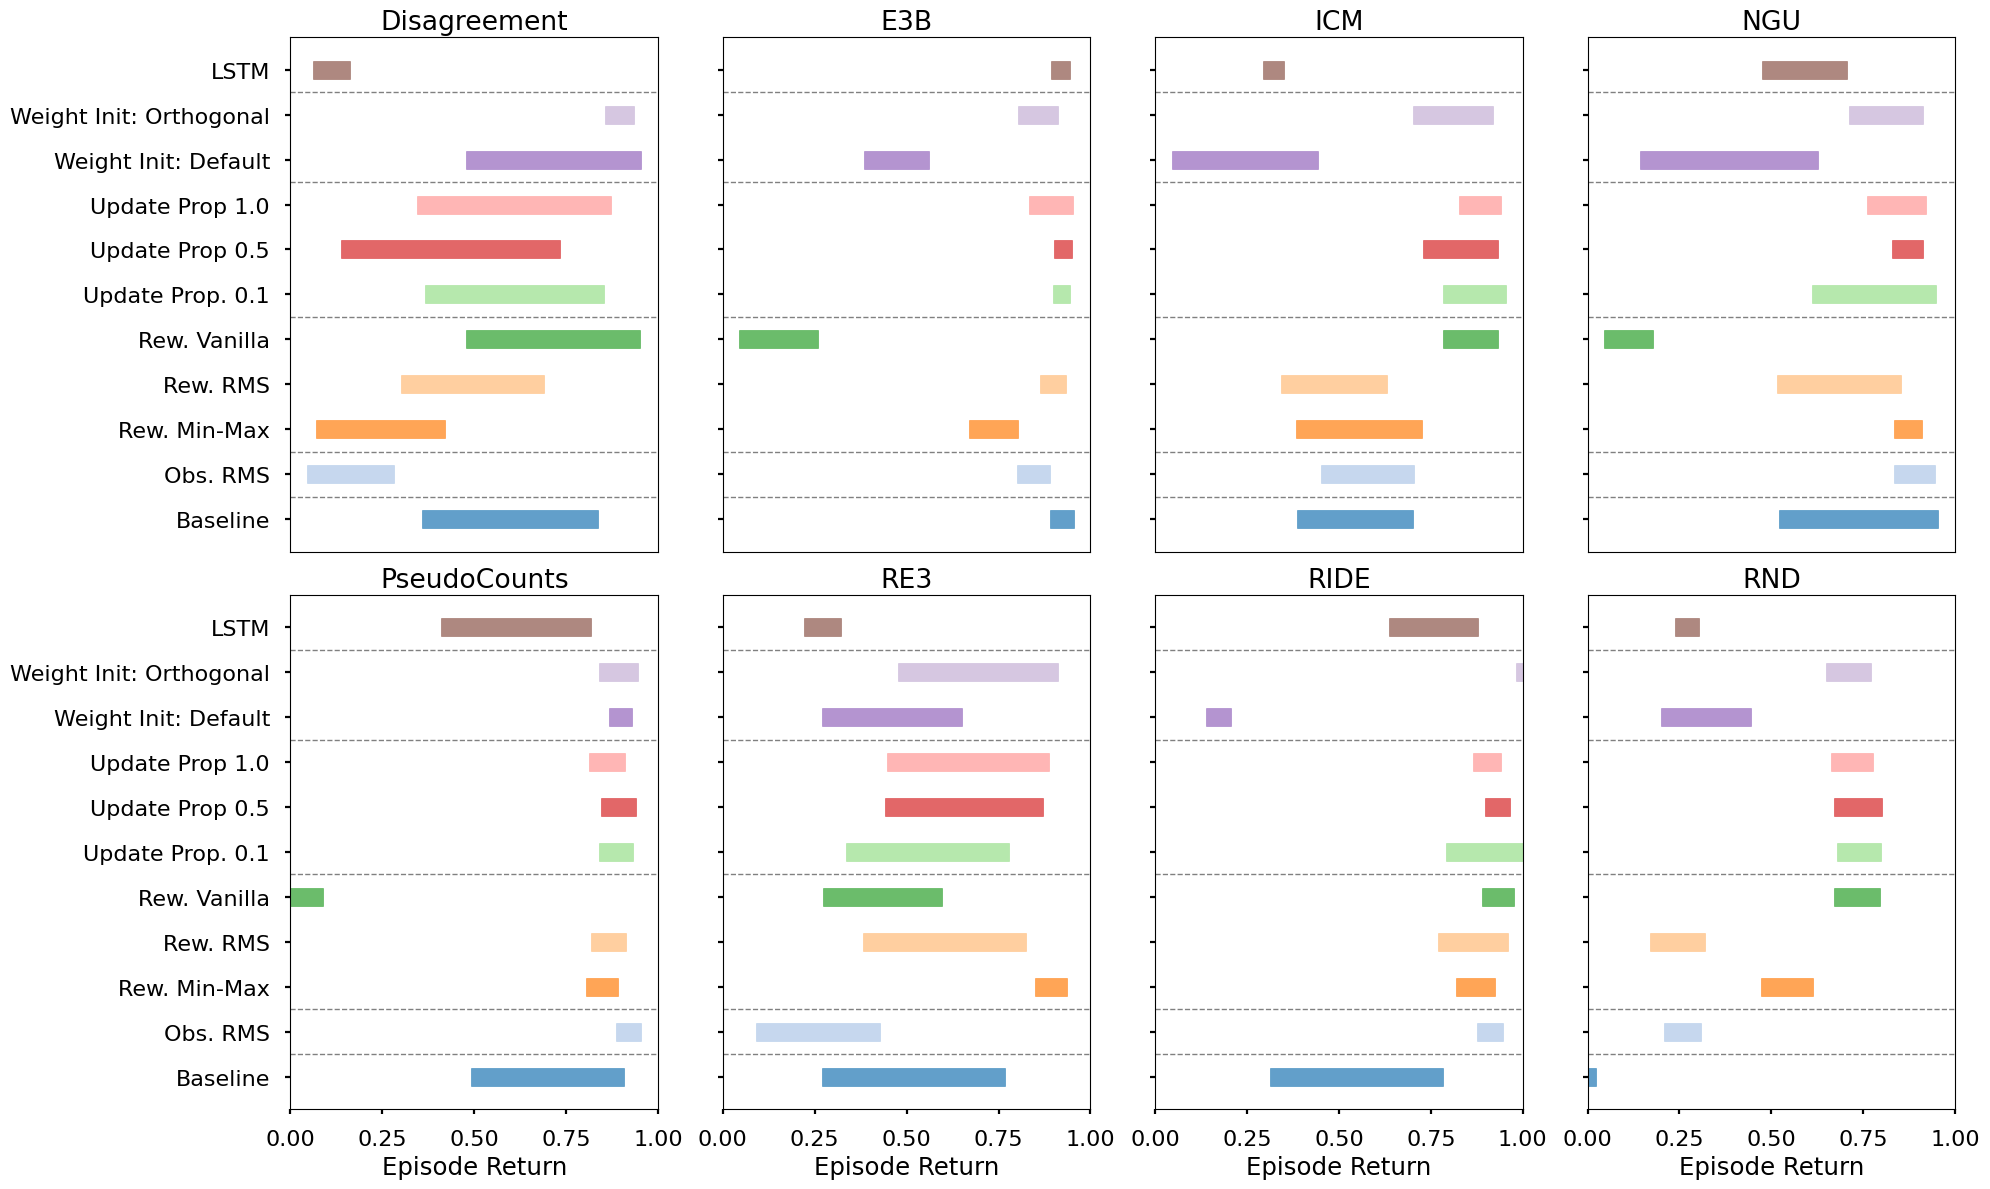

In [71]:
# Plotting
fig, ax = plt.subplots(2, 4, figsize=(20, 12), sharey=True)
y_labels_names = ["Baseline", "Obs. RMS", "Rew. Min-Max", "Rew. RMS", "Rew. Vanilla", "Update Prop. 0.1", "Update Prop 0.5", "Update Prop 1.0", "Weight Init: Default", "Weight Init: Orthogonal", "LSTM"]

for i, algo in enumerate(algos):
    subset = df[df['Algorithm'] == algo]
    col_idx = i % 4
    row_idx = i // 4
    ax[row_idx, col_idx].errorbar(subset['mean_normalized'], subset['RQ'], xerr=subset['std_normalized'], fmt='none', color=cmap(i), alpha=0)
    for j, (_, row) in enumerate(subset.iterrows()):
        color = cmap(j)  # Using modulo with length of subset to ensure cycling through colors
        ax[row_idx, col_idx].add_patch(Rectangle((row['mean_normalized'] - row['std_normalized'], j - 0.2), row['std_normalized'] * 2, 0.4, color=color, alpha=0.7))
    ax[row_idx, col_idx].set_title(algo)
    
    # draw horizontal dashed lines for between each RQ
    #ax[row_idx, col_idx].axhline(-0.5, color='black', linewidth=2)
    ax[row_idx, col_idx].axhline(0.5, color='gray', linestyle='--', linewidth=1)
    ax[row_idx, col_idx].axhline(1.5, color='gray', linestyle='--', linewidth=1)
    ax[row_idx, col_idx].axhline(4.5, color='gray', linestyle='--', linewidth=1)
    ax[row_idx, col_idx].axhline(7.5, color='gray', linestyle='--', linewidth=1)
    ax[row_idx, col_idx].axhline(9.5, color='gray', linestyle='--', linewidth=1)
    ax[row_idx, col_idx].grid(False)
    
    # x ticks should go from 0.1 to .9. Only on the 2cnd row
    if row_idx == 1:
        ax[row_idx, col_idx].set_xlim(0, 1)
        ax[row_idx, col_idx].set_xticks(np.linspace(0, 1, 5))
    else:
        # remove xticks
        ax[row_idx, col_idx].set_xticks([])
    
    
# Show x-axis labels only in the last row
for ax in ax[1, :]:
    ax.set_xlabel('Episode Return')

ax.set_yticklabels(y_labels_names)  # Set y-axis labels for the first subplot
plt.tight_layout()
plt.show()

# Best Curves (Figure 1)

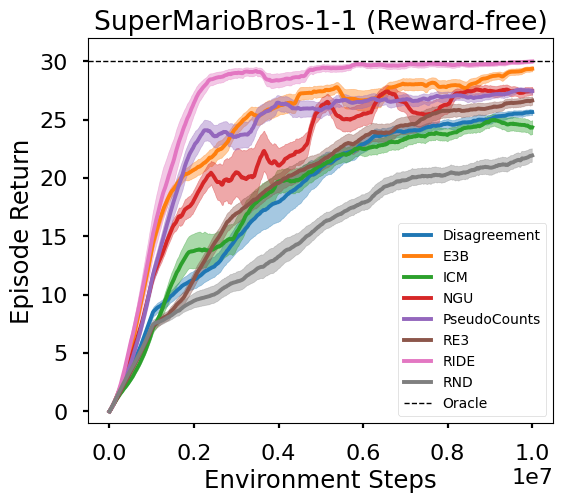

In [72]:
data_dir = "/home/roger/Desktop/rllte/best_mario_configs"
algorithms = ["Extrinsic", "RND", "ICM", "E3B", "PseudoCounts", "RIDE", "RE3", "NGU", "Disagreement"]
# Initialize an empty list to store dataframes for each experiment
dfs = []

# Loop through each subfolder
for subdir in os.listdir(data_dir):
    # Define the path to the current subfolder
    subfolder_path = os.path.join(data_dir, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each file in the subfolder
        for file in os.listdir(subfolder_path):
            if file == ".DS_Store":
                continue

            try:
                # Define the path to the file
                file_path = os.path.join(subfolder_path, file)

                seed = file_path.split("_")[-1][-1]
                if ".DS_Store" in nested:
                    nested.remove(".DS_Store")
                nested = nested[0]
                
                file_path = os.path.join(file_path, "train.log")
                
                algo_name = None
                for element in algorithms:
                    if element.lower() in file_path:
                        algo_name = element
                        
                        
                # Read the data from the file into a dataframe
                df = pd.read_csv(file_path)

                # Add a column to identify the algorithm
                df['RQ'] = subdir
                df["Algorithm"] = algo_name
                df['Seed'] = seed
                
                # Append the dataframe to the list
                dfs.append(df)
            except:
                print("Error with file: ", file_path)
                continue
            
# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

# aggregate by seed
summary_stats = data.groupby(['step', 'Algorithm'])['episode_reward'].agg(['mean', 'std']).reset_index()

## plot curves
colors = plt.cm.tab10.colors
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i, algo in enumerate(sorted(np.unique(summary_stats['Algorithm']))):
    subset = summary_stats[summary_stats['Algorithm'] == algo]
    mean_reward = subset['mean']
    std_reward = subset['std']
    
    window = 1000

    # append 0s at the beginning
    mean_reward = np.concatenate(([0] * window, mean_reward))
    std_reward = np.concatenate(([0] * window, std_reward))
    
    # smooth with np.convolve
    mean_reward = np.convolve(mean_reward, np.ones(window)/window, mode='valid')
    std_reward = np.convolve(std_reward, np.ones(window)/window, mode='valid') / 4
    
    x_axis = np.linspace(0, 10_000_000, len(mean_reward))

    # Use tab20 color palette
    color = colors[i % len(colors)]
    ax.plot(x_axis, mean_reward, label=algo, color=color)
    ax.fill_between(x_axis, mean_reward - std_reward, mean_reward + std_reward, alpha=0.4, color=color)
    
# hline at 30
ax.axhline(30, color='black', linestyle='--', linewidth=1, label='Oracle')

plt.ylim(-1, 32)

# put legend in one row bottom center
plt.legend(fontsize=10)
plt.xlabel('Environment Steps')
plt.ylabel('Episode Return')
plt.title("SuperMarioBros-1-1 (Reward-free)")
plt.show()

# Figure 1 (worst curves)

Error with file:  /home/roger/Desktop/rllte/baseline_mario_configs/PPO_SuperMarioBros-1-1-v3_extrinsic_obsRMS:False_rewNorm:rms_updateProp:1.0_rff:False_s1/2024-02-12-05-32-43/train.log


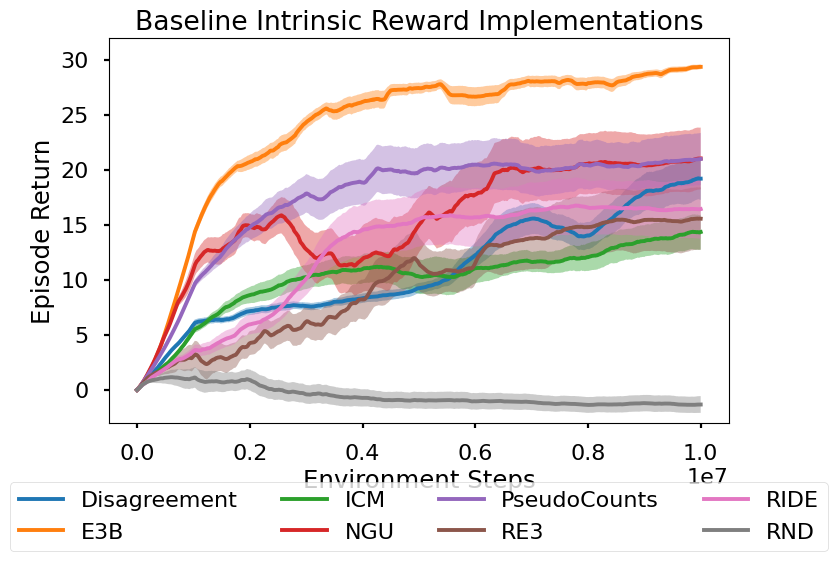

In [73]:
data_dir = "/home/roger/Desktop/rllte/baseline_mario_configs"
algorithms = ["RND", "ICM", "E3B", "PseudoCounts", "RIDE", "RE3", "NGU", "Disagreement"]
# Initialize an empty list to store dataframes for each experiment
dfs = []

# Loop through each subfolder
for subdir in os.listdir(data_dir):
    # Define the path to the current subfolder
    subfolder_path = os.path.join(data_dir, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each file in the subfolder
        for file in os.listdir(subfolder_path):
            if file == ".DS_Store":
                continue

            try:
                # Define the path to the file
                file_path = os.path.join(subfolder_path, file)

                seed = file_path.split("_")[-1][-1]
                if ".DS_Store" in nested:
                    nested.remove(".DS_Store")
                nested = nested[0]
                
                file_path = os.path.join(file_path, "train.log")
                
                algo_name = None
                for element in algorithms:
                    if element.lower() in file_path:
                        algo_name = element
                        
                        
                # Read the data from the file into a dataframe
                df = pd.read_csv(file_path)

                # Add a column to identify the algorithm
                df['RQ'] = subdir
                df["Algorithm"] = algo_name
                df['Seed'] = seed
                
                # Append the dataframe to the list
                dfs.append(df)
            except:
                print("Error with file: ", file_path)
                continue
            
# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

# aggregate by seed
summary_stats = data.groupby(['step', 'Algorithm'])['episode_reward'].agg(['mean', 'std']).reset_index()

# plot curves
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for algo in sorted(np.unique(summary_stats['Algorithm'])):
    subset = summary_stats[summary_stats['Algorithm'] == algo]
    mean_reward = subset['mean']
    std_reward = subset['std']
    
    window = 1000

    # append 0s at the beginning
    mean_reward = np.concatenate(([0] * window, mean_reward))
    std_reward = np.concatenate(([0] * window, std_reward))
    
    # smooth with np.convolve
    mean_reward = np.convolve(mean_reward, np.ones(window)/window, mode='valid')
    std_reward = np.convolve(std_reward, np.ones(window)/window, mode='valid') / 4
    
    x_axis = np.linspace(0, 10_000_000, len(mean_reward))
    ax.plot(x_axis, mean_reward, label=algo)
    ax.fill_between(x_axis, mean_reward - std_reward, mean_reward + std_reward, alpha=0.4)
    
    
plt.ylim(-3, 32)

# put legend in one row bottom center
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=4, fancybox=True)
plt.xlabel('Environment Steps')
plt.ylabel('Episode Return')
plt.title("Baseline Intrinsic Reward Implementations")
plt.show()


# RQ 7 and 8: Contextual MDPs and Mixed Rewards

In [74]:
data_dir = "/home/roger/Desktop/rllte/marioRandomStages_q578"

algorithms = ["Extrinsic", "RND", "ICM", "E3B", "PseudoCounts", "RIDE", "RE3", "NGU", "Disagreement"]
algorithms_mixed = ["E3B+ICM", "E3B+RND", "E3B+RIDE", "ICM+RIDE", "ICM+RND", "RE3+ICM", "RE3+RND", "RE3+RIDE", "RIDE+RND"]

dfs = []

# Loop through each subfolder
for subdir in os.listdir(data_dir):
    # Define the path to the current subfolder
    subfolder_path = os.path.join(data_dir, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each file in the subfolder
        for file in os.listdir(subfolder_path):
            if file == ".DS_Store":
                continue
            
            algo_name = None
            for algo in algorithms_mixed:
                if algo.lower() in file:
                    algo_name = algo
            
            if algo_name is None:
                for element in algorithms:
                    if element.lower() in file:
                        algo_name = element
                        
            try:
                # Define the path to the file
                file_path = os.path.join(subfolder_path, file)
                nested = os.listdir(file_path)

                seed = file_path.split("_")[-1][-1]
                if ".DS_Store" in nested:
                    nested.remove(".DS_Store")
                nested = nested[0]
                
                file_path = os.path.join(file_path, nested, "train.log")
                # Read the data from the file into a dataframe
                df = pd.read_csv(file_path)

                # Add a column to identify the algorithm
                df['RQ'] = subdir
                df["Algorithm"] = algo_name
                df['Seed'] = seed
                df['Has_Plus'] = df['Algorithm'].str.contains('\+')
                
                # keep last 100 episodes
                df = df.iloc[-1000:]
                
                # Append the dataframe to the list
                dfs.append(df)
            except:
                print("Error with file: ", file_path)
                continue
            
# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)


Error with file:  /home/roger/Desktop/rllte/marioRandomStages_q578/mixed_lstm/None_PPO_SuperMarioBrosRandomStages-v3_e3b+icm+ride+rnd+disagreement+re3_obsRMS:False_rewNorm:rms_updateProp:1.0_rff:False_s0


In [75]:
# compute the mean and std only on the last 100 episodes
summary_stats = data.groupby(['Algorithm', "RQ", 'Has_Plus'])['episode_reward'].agg(['mean', 'std']).reset_index()
summary_stats['mean_normalized'] = (summary_stats['mean'] - 0) / (35 - 0)  # Min-max normalization
summary_stats['std_normalized'] = (summary_stats['std'] - 0) / (35 - 0)  / 4 # Min-max normalization 
df = summary_stats
df = df.sort_values(by='Has_Plus', ascending=False).drop(columns='Has_Plus')


# remove extrinsic 
df = df[df['Algorithm'] != 'Extrinsic']

algos = np.unique(df['Algorithm'])
RQs = np.unique(df['RQ'])

rq_mapping = {
    'baseline': 'Baseline',
    'lstm': 'LSTM',
    'mixed': 'Mixed Baseline',
    'mixed_lstm': 'Mixed + LSTM'
}

custom_palette = {
    "Baseline": "tab:blue",
    "LSTM": "tab:orange",
    "Mixed Baseline": "tab:blue",
    "Mixed + LSTM": "tab:orange"
    
}

# Apply the mapping to the 'RQ' column in your DataFrame
df['RQ'] = df['RQ'].map(rq_mapping)

{'Baseline': 'tab:blue', 'LSTM': 'tab:orange', 'Mixed Baseline': 'tab:blue', 'Mixed + LSTM': 'tab:orange'}


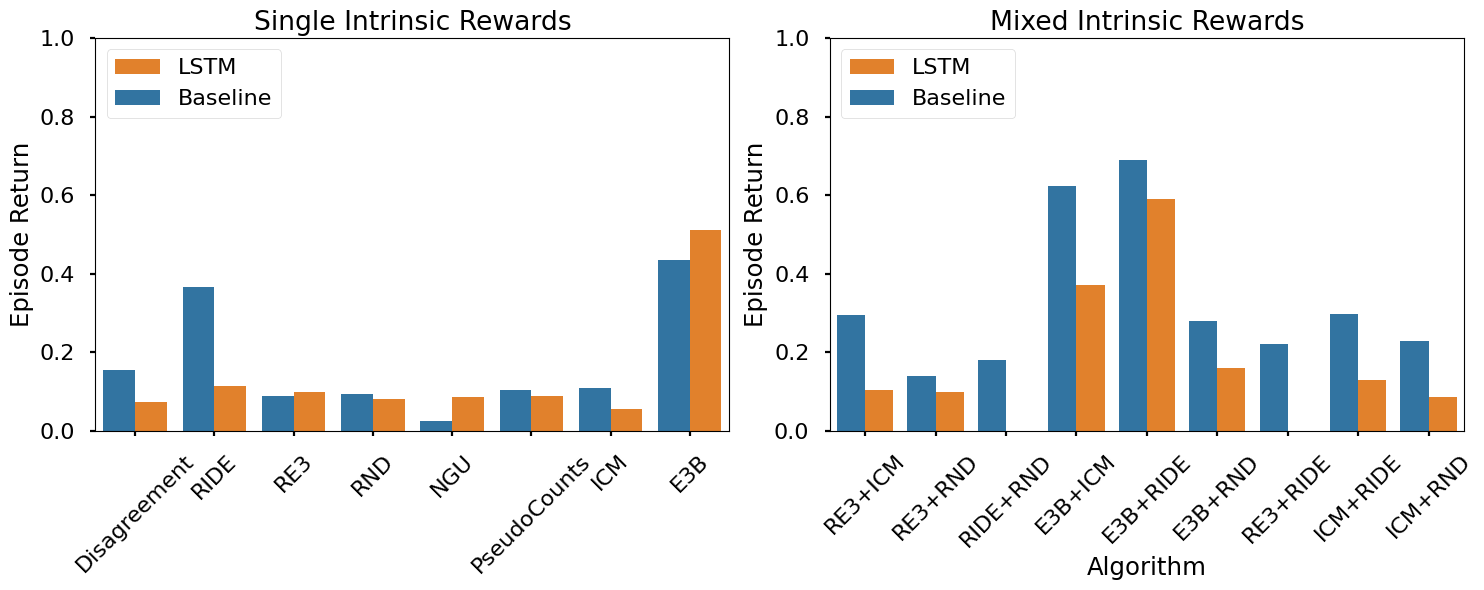

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data for normal algorithms and mixed algorithms separately
normal_algorithms = df[~df['Algorithm'].str.contains('\+')]
mixed_algorithms = df[df['Algorithm'].str.contains('\+')]

# Set up the figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

print(custom_palette)

# Plot for normal algorithms
sns.barplot(data=normal_algorithms, x='Algorithm', y='mean_normalized', hue='RQ', ax=axes[0], palette=custom_palette)
axes[0].set_title('Single Intrinsic Rewards')
axes[0].set_ylabel('Episode Return')
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('') 

# Plot for mixed algorithms
sns.barplot(data=mixed_algorithms, x='Algorithm', y='mean_normalized', hue='RQ', ax=axes[1], palette=custom_palette)
axes[1].set_title('Mixed Intrinsic Rewards')
axes[1].set_ylabel('Episode Return')
axes[1].set_ylim(0, 1)
axes[0].set_xlabel('')


# Rotate x-axis labels for better readability
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

# Get legend handles and labels
handles, labels = axes[0].get_legend_handles_labels()

# Define the order for legend entries
order = [1,0]  # Adjust the order as needed

# Set legend with sorted entries
axes[0].legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left')
axes[1].legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left')


# Adjust layout to prevent overlap
plt.tight_layout()
# Show plots
plt.show()

# R8 mixed Rewards in Mario 1-1 

In [77]:
data_dir = "/home/roger/Desktop/rllte/mario_mixed"

algorithms = ["E3B+ICM", "E3B+RND", "E3B+RIDE", "ICM+RIDE", "ICM+RND", "RE3+ICM", "RE3+RND", "RE3+RIDE" "RIDE+RND"]
# Initialize an empty list to store dataframes for each experiment
dfs = []
cmap = get_cmap('tab20')

# Loop through each subfolder
for subdir in os.listdir(data_dir):
    # Define the path to the current subfolder
    subfolder_path = os.path.join(data_dir, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each file in the subfolder
        for file in os.listdir(subfolder_path):
            if file == ".DS_Store":
                continue
            
            algo_name = None
            for element in algorithms:
                if element.lower() in file:
                    algo_name = element

            try:
                # Define the path to the file
                file_path = os.path.join(subfolder_path, file)
                nested = os.listdir(file_path)

                seed = file_path.split("_")[-1][-1]
                if ".DS_Store" in nested:
                    nested.remove(".DS_Store")
                nested = nested[0]
                
                file_path = os.path.join(file_path, nested, "train.log")
                # Read the data from the file into a dataframe
                df = pd.read_csv(file_path)

                # Add a column to identify the algorithm
                df['RQ'] = subdir
                df["Algorithm"] = algo_name
                df['Seed'] = seed
                
                # keep last 100 episodes
                df = df.iloc[-1000:]
                
                # Append the dataframe to the list
                dfs.append(df)
            except:
                print("Error with file: ", file_path)
                continue
            
# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_2609476/3850933589.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


In [78]:

# compute the mean and std only on the last 100 episodes
summary_stats = data.groupby(['RQ', 'Algorithm'])['episode_reward'].agg(['mean', 'std']).reset_index()
summary_stats['mean_normalized'] = (summary_stats['mean'] - 0) / (30 - 0)  # Min-max normalization
summary_stats['std_normalized'] = (summary_stats['std'] - 0) / (30 - 0)  / 2# Min-max normalization 
df = summary_stats

# remove extrinsic 
df = df[df['Algorithm'] != 'Extrinsic']

algos = np.unique(df['Algorithm'])
RQs = np.unique(df['RQ'])

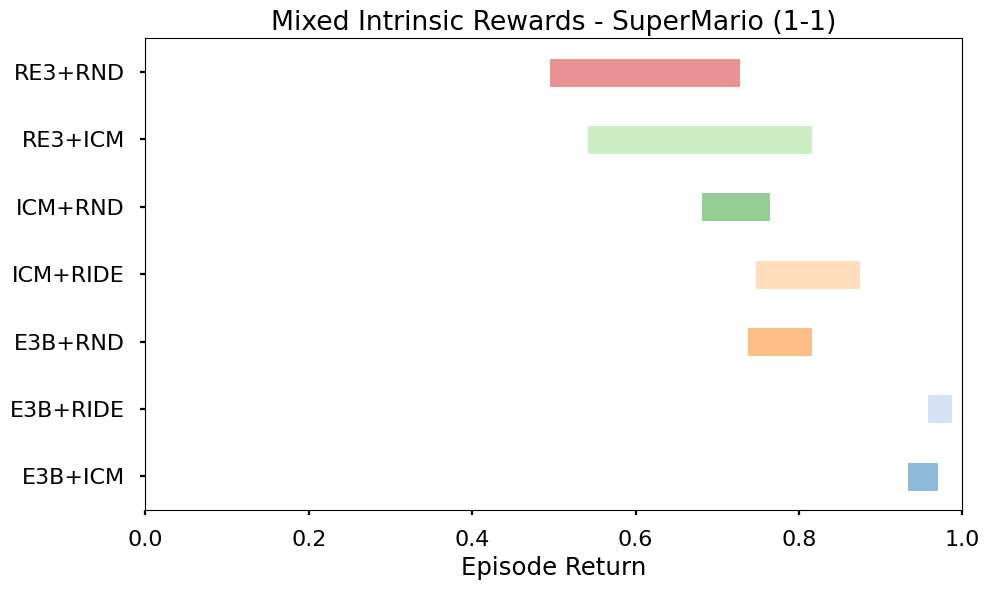

In [79]:

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y_labels_names = df['Algorithm']

for i, (_, row) in enumerate(df.iterrows()):
    color = cmap(i % 20)  # Using modulo with length of cmap to ensure cycling through colors
    ax.add_patch(Rectangle((row['mean_normalized'] - row['std_normalized'], i - 0.2), row['std_normalized'] * 2, 0.4, color=color, alpha=0.5))

ax.set_yticks(np.arange(len(df)))
ax.set_yticklabels(y_labels_names)
ax.set_xlabel('Episode Return')
ax.set_title('Mixed Intrinsic Rewards - SuperMario (1-1)')
ax.set_ylim(-0.5, len(df) - 0.5)

plt.tight_layout()
plt.show()
